In [92]:
import os
import sys
import pandas
import numpy

import findspark
findspark.init("/usr/local/spark/spark")

import pyspark
from pyspark.sql.window import Window
import pyspark.sql.functions as func

from pyspark.rdd import reduce
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeansModel, KMeans
from pyspark.ml.linalg import SparseVector, VectorUDT, Vector, Vectors

In [13]:
import matplotlib.pyplot as plt

In [2]:
file_name = "/Users/simondi/PHD/data/data/target_infect_x/query_data/cells_sample_10_normalized.tsv"

In [3]:
conf = pyspark.SparkConf().setMaster("local[*]").set("spark.driver.memory", "4G").set("spark.executor.memory", "4G")
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.sql.SparkSession(sc)

In [4]:
df = spark.read.csv(path=file_name, sep="\t", header='true')

In [5]:
old_cols = df.schema.names
new_cols = list(map(lambda x: x.replace(".", "_"), old_cols))

df = reduce(
  lambda data, idx: data.withColumnRenamed(old_cols[idx], new_cols[idx]),
  range(len(new_cols)), df)

for i, x in enumerate(new_cols):
    if x.startswith("cells") or x.startswith("perin") or x.startswith("nucl"):
        df = df.withColumn(x, df[x].cast("double"))

df = df.fillna(0)

In [6]:
feature_columns = [x for x in df.columns if x.startswith("cells") or x.startswith("perin") or x.startswith("nucl")]
assembler = VectorAssembler(inputCols=feature_columns,outputCol='features')
data = assembler.transform(df)

In [7]:
data = data.limit(30)

In [8]:
data.write.parquet("/Users/simondi/Desktop/bla" + "_normalized_parquet", mode="overwrite")

In [9]:
blub = spark.read.parquet("/Users/simondi/Desktop/bla"+ "_normalized_parquet")

In [10]:
kmean_fits = []
for k in range(2, 11):
    km = KMeans().setK(k).setSeed(23)
    model = km.fit(data)
    kmean_fits.append((k, model, model.computeCost(data)))

In [86]:
for fit in kmean_fits:
    fit[1].write().overwrite().save("/Users/simondi/Desktop/bla_" + str(fit[0]))

In [11]:
ks =   [x[0] for x in kmean_fits]
mses = [x[2] for x in kmean_fits]

In [80]:
font = {'weight' : 'normal',
        'family':'sans-serif',
        'size'   : 14}
plt.rc('font', **font)

In [81]:
ax = plt.subplot(111)    
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)

/Users/simondi/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


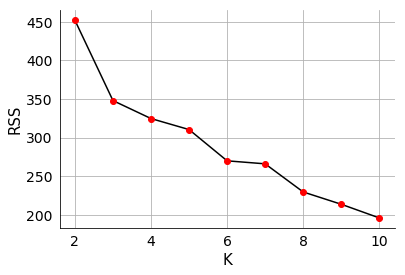

In [82]:
ax.plot(ks, mses, "black")
ax.plot(ks, mses, "or")
plt.xlabel('K', fontsize=15)
plt.ylabel('RSS', fontsize=15)
plt.title('')
ax.grid(True)
plt.savefig("/Users/simondi/PROJECTS/target_infect_x_project/plots/k_means_clustering_test", bbox_inches="tight")  
plt.show()

In [ ]:
spark.stop()